<a href="https://colab.research.google.com/github/farhan1503001/Generative-Deep-Learning-With-Tensorflow/blob/main/Neural%20Style%20Transfer/Neural_Style_Transfer_With_Total_Variation_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural Style Transfer**

**Importing Libraries**

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K

from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

**Utility Function Implementation**

In [2]:
def tensor_to_image(tensor):
  '''converts a tensor to an image'''
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor) 


def load_img(path_to_img):
  '''loads an image as a tensor and scales it to 512 pixels'''
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)

  return image


def load_images(content_path, style_path):
  '''loads the content and path images as tensors'''
  content_image = load_img("{}".format(content_path))
  style_image = load_img("{}".format(style_path))

  return content_image, style_image


def imshow(image, title=None):
  '''displays an image with a corresponding title'''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)
    
    
def show_images_with_objects(images, titles=[]):
  '''displays a row of images with corresponding titles'''
  if len(images) != len(titles):
    return

  plt.figure(figsize=(20, 12))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), idx + 1)
    plt.xticks([])
    plt.yticks([])
    imshow(image, title)


def display_gif(gif_path):
  '''displays the generated images as an animated gif'''
  with open(gif_path,'rb') as f:
    display_fn(Image(data=f.read(), format='png'))


def create_gif(gif_path, images):
  '''creates animation of generated images'''
  mimsave(gif_path, images, fps=1)
  
  return gif_path


def clip_image_values(image, min_value=0.0, max_value=255.0):
  '''clips the image pixel values by the given min and max'''
  return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)


def preprocess_image(image):
  '''centers the pixel values of a given image to use with VGG-19'''
  image = tf.cast(image, dtype=tf.float32)
  image = tf.keras.applications.vgg19.preprocess_input(image)

  return image


# Downloading Data

In [3]:
IMAGE_DIR = 'images'

# create directory
!mkdir {IMAGE_DIR}

# download images to the directory you just created
!wget -q -O ./images/cafe.jpg https://cdn.pixabay.com/photo/2018/07/14/15/27/cafe-3537801_1280.jpg
!wget -q -O ./images/swan.jpg https://cdn.pixabay.com/photo/2017/02/28/23/00/swan-2107052_1280.jpg
!wget -q -O ./images/tnj.jpg https://i.dawn.com/large/2019/10/5db6a03a4c7e3.jpg
!wget -q -O ./images/rudolph.jpg https://cdn.pixabay.com/photo/2015/09/22/12/21/rudolph-951494_1280.jpg
!wget -q -O ./images/dynamite.jpg https://cdn.pixabay.com/photo/2015/10/13/02/59/animals-985500_1280.jpg
!wget -q -O ./images/painting.jpg https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg

print("image files you can choose from: ")
!ls images

image files you can choose from: 
cafe.jpg  dynamite.jpg	painting.jpg  rudolph.jpg  swan.jpg  tnj.jpg


**Setting Content and Style Image**

In [4]:
# set default images
content_path = f'{IMAGE_DIR}/swan.jpg'
style_path = f'{IMAGE_DIR}/painting.jpg'

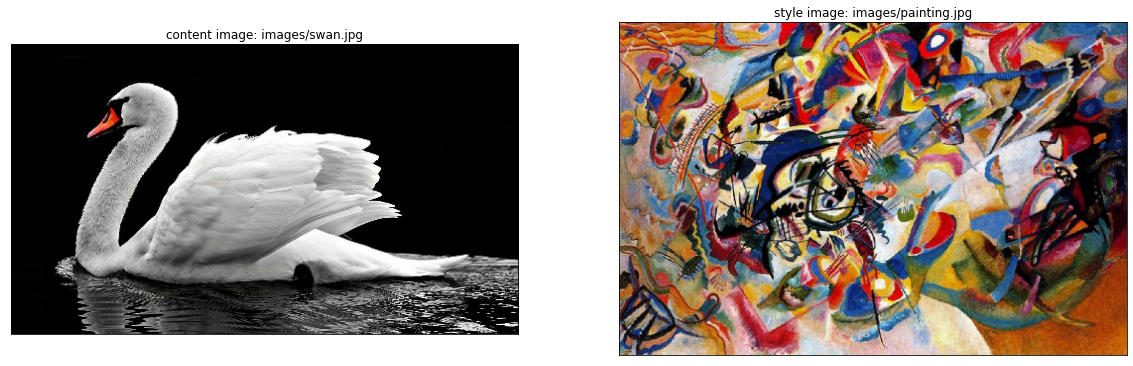

In [5]:
# display the content and style image
content_image, style_image = load_images(content_path, style_path)
show_images_with_objects([content_image, style_image], 
                         titles=[f'content image: {content_path}',
                                 f'style image: {style_path}'])

# Building The Model

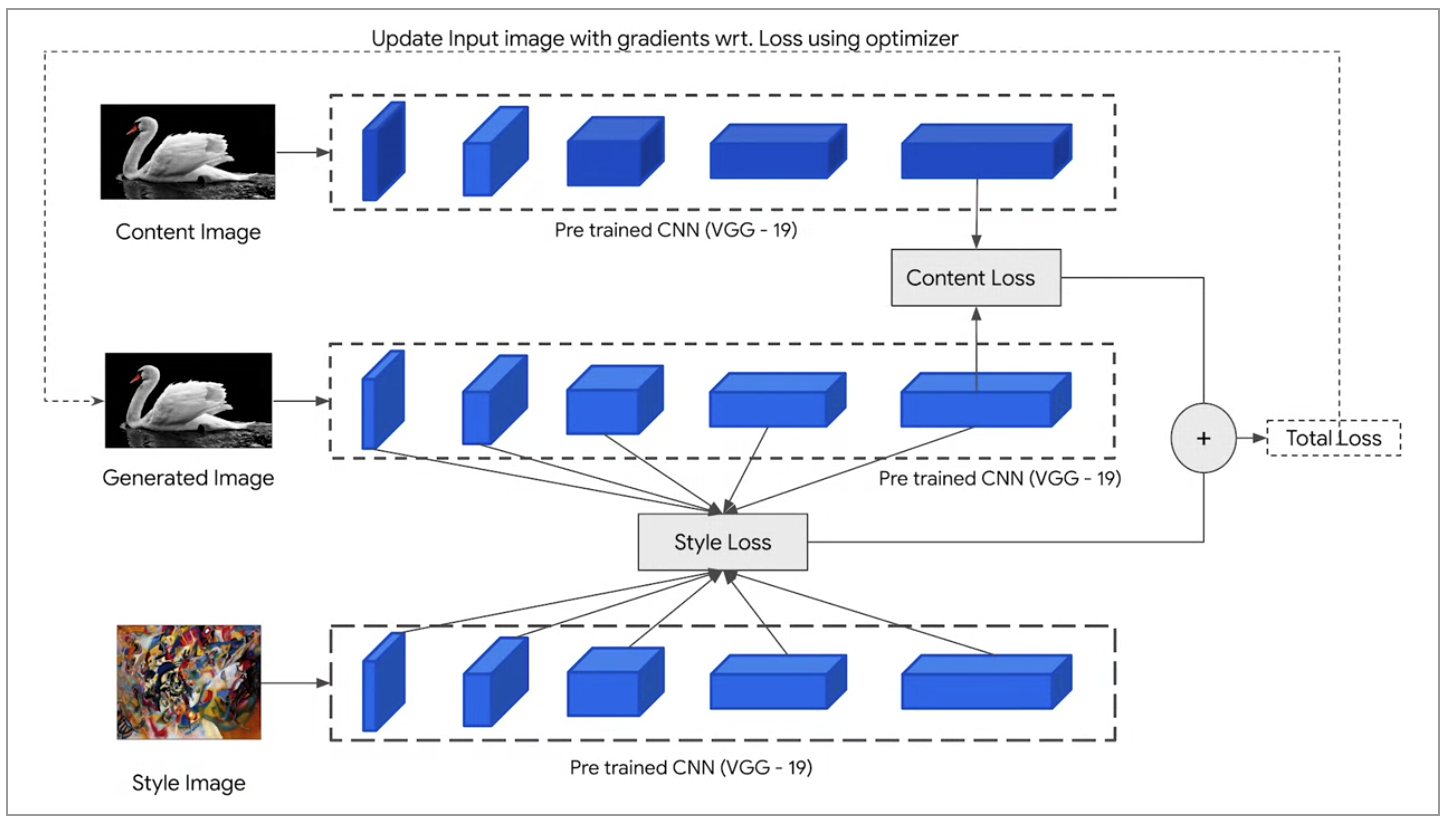

**Here we will use VGG-16 Model as extractor**

In [6]:
#Now clearing the session first
K.clear_session()
#Now take the vgg extractor
tmp_vgg=tf.keras.applications.vgg19.VGG19()
tmp_vgg.summary()

del tmp_vgg

574726144/574710816 [==============================] - 10s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

**Now defining style layers and content layers**

In [7]:
style_layers=[
              'block1_conv1',
              'block2_conv1',
              'block3_conv1',
              'block4_conv1',
              'block5_conv1'
]

content_layers=['block5_conv2']

output_layers=style_layers+content_layers

num_content_layer=len(content_layers)
num_style_layer=len(style_layers)

**Creating Vgg model**

In [8]:
def vgg_model(layers):
  """
  outputs a vgg model with style or content layer activations
  Input:
  input layer names
  """
  vgg_model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
  vgg_model.trainable=False
  #Now output layers in a list
  outputs=[vgg_model.get_layer(layer).output for layer in layers]

  #Now defining model
  model=tf.keras.Model(inputs=vgg_model.input,outputs=outputs)

  return model

**Fir checking **

In [9]:
K.clear_session()

vgg=vgg_model(output_layers)
vgg.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

# Defining Loss Functions

**In this part we are defining style,content and total variation loss functions**

In [10]:
def get_style_loss(features,targets):
  """
  Inputs two image style and target and outputs 
  loss between them
  """
  style_loss=tf.reduce_sum(tf.square(targets-features))

  return style_loss

In [11]:
#Now content loss
def get_content_loss(features,targets):
  """
  Takes two images features and targets as inputs
  and outputs content loss along with a weight parameter
  """
  content_loss=0.5*tf.reduce_sum(tf.square(targets-features))

  return content_loss

**Function for calculating gram metrix using einstein summation**

In [12]:
def gram_matrix(input_tensor):
  """
  Inputs an input tensor and outputs it's gram matrix
  """
  gram=tf.linalg.einsum('bijc,bijd->bcd',input_tensor,input_tensor)
  #Now we find input shape
  input_shape=tf.shape(input_tensor)
  height=input_shape[1]
  width=input_shape[2]
  #Now getting the number of locations
  num_locations=tf.cast(height*width,tf.float32)
  #now normalized gram matrix
  norm_gram=gram/num_locations

  return norm_gram

# Feature extraction

**For every style layer find out it's output**

In [13]:
def get_style_features(image):
  """
  Inputs layers in input and finds out gram matrix for each one of them
  """
  preprocessed_image=preprocess_image(image)
  #Now finding out output
  outputs=vgg(preprocessed_image)
  #Now just taking only style ones
  style_outputs=outputs[:num_style_layer]
  #now finding gram matrix for each of them
  gram_style_features=[gram_matrix(layer) for layer in style_outputs]

  return gram_style_features

**Now getting content loss**

In [14]:
def get_content_features(image):
  """
  Get the content loss features

  """
  preprocessed_image=preprocess_image(image)

  outputs=vgg(preprocessed_image)

  content_outputs=outputs[num_style_layer:]

  return content_outputs

# Getting total loss L=astyle_loss+bcontent loss

In [15]:
def get_style_content_loss(style_features,style_outputs,content_features,content_outputs,style_weight,content_weight):
  """
  Combine the content and style loss
  returns total loss
  """

  style_loss=tf.add_n([get_style_loss(style_outputs,style_features) for style_outputs,style_features 
                       in zip(style_outputs,style_features)])
  
  content_loss=tf.add_n([get_content_loss(content_outputs,content_features) for content_outputs,content_features 
                         in zip(content_outputs,content_features)])
  
  t_style_loss=style_weight*style_loss/num_style_layer
  t_content_loss=content_weight*content_loss/num_content_layer
  total_loss=t_style_loss+t_content_loss

  return total_loss

# Generate Stylized Image

**Computing Gradients**

In [16]:
def calculate_gradients(image,style_targets,content_targets,style_weight,
                        content_weight,var_weight):
  """
  Calculate the gradients of loss with respect to generated image
  """
  with tf.GradientTape() as tape:
    style_features=get_style_features(image)

    content_features=get_content_features(image)


    loss=get_style_content_loss(style_targets,style_features,content_features,content_targets,style_weight,content_weight)

  gradients=tape.gradient(loss,image)

  return gradients

In [17]:
def update_image_with_style(image, style_targets, content_targets, style_weight, 
                            var_weight, content_weight, optimizer):
  """
  Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss
    optimizer: optimizer for updating the input image
  """

  # calculate gradients using the gradients function

  gradients=calculate_gradients(image,style_targets,content_targets,style_weight,content_weight,var_weight)
  #Apply the gradients
  optimizer.apply_gradients([(gradients,image)])

  image.assign(clip_image_values(image,min_value=0.0,max_value=255.0))

# Generate Stylized Image

In [18]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4, 
                       var_weight=0, optimizer='adam', epochs=1, steps_per_epoch=1):
  """ Performs neural style transfer.
  Args:
    style_image: image to get style features from
    content_image: image to stylize 
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss
    optimizer: optimizer for updating the input image
    epochs: number of epochs
    steps_per_epoch = steps per epoch
  
  Returns:
    generated_image: generated image at final epoch
    images: collection of generated images per epoch  
  """

  images = []
  step = 0

  # get the style image features 
  style_targets = get_style_features(style_image)
    
  # get the content image features
  content_targets=get_content_features(content_image)

  # Without making generated image a variable gradients cannot be applied
  generated_image=tf.cast(content_image,dtype=tf.float32)
  generated_image=tf.Variable(generated_image)
  
  # collect the image updates starting from the content image
  images.append(content_image)
  
  # incrementally update the content image with the style features
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
    
      # Update the image with the style using the function that you defined
      update_image_with_style(generated_image, style_targets, content_targets, 
                              style_weight, var_weight, content_weight, optimizer) 
    
      print(".", end='')

      if (m + 1) % 10 == 0:
        images.append(generated_image)
    
    # display the current stylized image
    clear_output(wait=True)
    display_image = tensor_to_image(generated_image)
    display_fn(display_image)

    # append to the image collection for visualization later
    images.append(generated_image)
    print("Train step: {}".format(step))
  
  # convert to uint8 (expected dtype for images with pixels in the range [0,255])
  generated_image = tf.cast(generated_image, dtype=tf.uint8)

  return generated_image, images

Running the stylizer

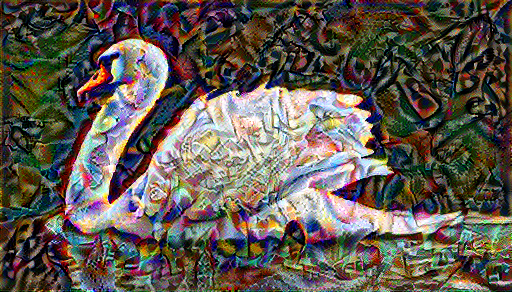

Train step: 1000


In [19]:
# define style and content weight
style_weight =  2e-2
content_weight = 1e-2 

# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=20.0, decay_steps=100, decay_rate=0.50
    )
)

# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image, 
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    var_weight=0, optimizer=adam, epochs=10, steps_per_epoch=100)